In [88]:
import pandas as pd
import numpy as np 
import math, datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
plt.style.use(style='ggplot')

In [64]:
df = pd.read_csv("RAYA Historical Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])
df = df.rename(columns={'Change %': 'HL_PCT', 'Price': 'Close', 'Vol.': 'Volume'})
df['Volume'] = df['Volume'].replace('[A-z]', '', regex=True)
df['Volume'] = df['Volume'].astype(float)
df['PCT_CHANGE'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

df = df[['Close','HL_PCT','PCT_CHANGE','Volume']]
df

,Close,HL_PCT,PCT_CHANGE,Volume
Date,,,,
2024-01-24,4.60,10.84%,8.235294,18.01
2024-01-23,4.15,3.75%,2.722772,8.34
2024-01-22,4.00,-0.99%,-2.912621,8.56
2024-01-21,4.04,-1.70%,-2.650602,5.55
2024-01-18,4.11,2.24%,0.735294,17.12
...,...,...,...,...
2021-02-03,2.71,10.00%,0.000000,1.70
2021-02-02,2.46,9.87%,4.680851,2.31
2021-02-01,2.24,18.33%,7.692308,5.60


In [62]:
forecast_out = int(math.ceil(0.1*len(df)))


df['label'] = df['Close'].shift(-forecast_out)
df

,Close,HL_PCT,PCT_CHANGE,Volume,label
Date,,,,,
2024-01-24,4.60,10.84%,8.235294,18.01,2.13
2024-01-23,4.15,3.75%,2.722772,8.34,2.12
2024-01-22,4.00,-0.99%,-2.912621,8.56,2.10
2024-01-21,4.04,-1.70%,-2.650602,5.55,2.10
2024-01-18,4.11,2.24%,0.735294,17.12,2.21
...,...,...,...,...,...
2021-02-03,2.71,10.00%,0.000000,1.70,NaN
2021-02-02,2.46,9.87%,4.680851,2.31,NaN
2021-02-01,2.24,18.33%,7.692308,5.60,NaN


<AxesSubplot:xlabel='Date', ylabel='Close'>

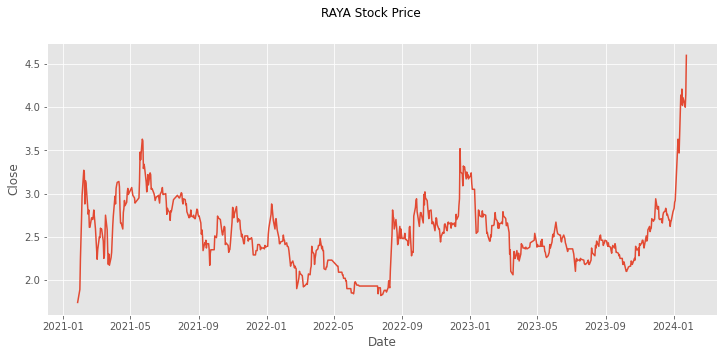

In [70]:
fig = plt.figure(figsize=(12, 5))
title = fig.suptitle("RAYA Stock Price")
sns.lineplot(data=df, x=df.index, y=df['Close'])


In [71]:
obj = df.select_dtypes(include='object')
for i in obj.columns:
     le1 = LabelEncoder()
     df[i] = le1.fit_transform(df[i])

In [72]:
from sklearn import preprocessing,neighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LinearRegression
from sklearn import metrics 

In [74]:
X = np.array(df.drop(columns = 'label'))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
Y = np.array(df['label'])
Y =Y[0:len(X)]


In [75]:
def print_errors(true,predicted):
    MAE =  metrics.mean_absolute_error(true,predicted)
    MSE = metrics.mean_squared_error(true,predicted)
    RMSE  = np.sqrt(metrics.mean_squared_error(true,predicted))
    r2_score = metrics.r2_score(true,predicted)
    print(f'MAE : {MAE}')
    print(f'MSE : {MSE}')
    print(f'RMSE : {RMSE}')
    print(f'r2_score : {r2_score}')
    
    
def evalute_errors(true,predicted):
    MAE =  metrics.mean_absolute_error(true,predicted)
    MSE = metrics.mean_squared_error(true,predicted)
    RMSE  = np.sqrt(metrics.mean_squared_error(true,predicted))
    r2_score = metrics.r2_score(true,predicted)
    return MAE,MSE,RMSE,r2_score

In [83]:
from xgboost import XGBRegressor

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.3)

regr = XGBRegressor()
regr.fit(x_train, y_train)
regr_score = regr.score(x_train,y_train)

forecast_set= regr.predict(X_lately)
print(forecast_set,accuracy, forecast_out)


[2.4585311 2.4076297 2.26564   2.349813  2.357696  2.2928982 2.3383796
 2.3517902 2.0890625 2.2164214 2.387018  2.2270067 2.2508948 2.2310524
 2.2244184 2.2577622 2.2793112 2.2262697 2.2048104 2.1848078 2.2286615
 2.2015753 2.275524  2.2311    2.1963205 2.1854775 2.2526588 2.369594
 2.3169622 2.3072271 2.3048942 2.2756891 2.1066656 2.383161  2.1077602
 2.4325864 2.5014021 2.7846072 2.218075  2.52078   2.3907688 2.4612346
 2.1771078 2.407433  2.1940148 2.2377515 2.4333081 2.4117193 2.3864374
 2.4225843 2.3939776 2.3720882 2.3433576 2.3118975 2.3665469 2.3883557
 2.349813  2.42321   2.374043  2.32301   2.3278499 2.3188229 2.2898226
 2.3137922 2.3054693 2.259592  2.20368   2.183389  2.2245467 2.366636
 2.1105416 2.1414378 2.1226633] 0.18213308345531465 73


In [89]:
df['Forecast'] = np.nan


last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [90]:
df

,Close,HL_PCT,PCT_CHANGE,Volume,label,Forecast
Date,,,,,,
2024-01-24 00:00:00,4.60,323.0,8.235294,18.01,2.13,NaN
2024-01-23 00:00:00,4.15,388.0,2.722772,8.34,2.12,NaN
2024-01-22 00:00:00,4.00,41.0,-2.912621,8.56,2.10,NaN
2024-01-21 00:00:00,4.04,81.0,-2.650602,5.55,2.10,NaN
2024-01-18 00:00:00,4.11,339.0,0.735294,17.12,2.21,NaN
...,...,...,...,...,...,...
2021-07-27 03:00:00,NaN,NaN,NaN,NaN,NaN,2.224547
2021-07-28 03:00:00,NaN,NaN,NaN,NaN,NaN,2.366636
2021-07-29 03:00:00,NaN,NaN,NaN,NaN,NaN,2.110542


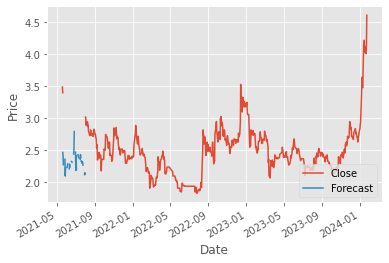

In [91]:
df['Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
